In [1]:
import sys
sys.path.append("..")

from pathlib import Path
import pandas as pd
import nibabel as nib

from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance

from bold_dementia.data.memento import Memento
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices

BIDSDIR = Path("/georges/memento/BIDS")
PPATH = Path("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv")
ATLAS = "schaeffer"
SOFT = False
confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}

phenotypes = Memento.load_phenotypes(PPATH)

# TODO Schaeffer and group by networks

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
no_dementia_mask = phenotypes.days_to_onset.isna()
controls = phenotypes[no_dementia_mask].sample(n=2, random_state=1234)
AD_mask = ((phenotypes.MA == 1))
demented = phenotypes[AD_mask].sample(2, random_state=1234)
subjects = pd.concat([demented, controls])

In [3]:
from nilearn.interfaces.bids import get_bids_files, parse_bids_filename
fmri_path = get_bids_files(
    BIDSDIR / "derivatives/fmriprep-23.2.0",
    "bold",
    modality_folder="func",
    file_type="nii.gz",
    filters=[
    #    #("space", "MNI152NLin2009cAsym")
        ("space", "MNI152NLin6Asym"),
        ("ses", "M000")
    ],
)

In [4]:
# TODO SCAN TO ONSET!!!
df = pd.DataFrame(map(parse_bids_filename, fmri_path))

rest_dataset = pd.merge(
    left=df,
    right=subjects,
    how="left",
    on="sub"
)
rest_dataset = rest_dataset.dropna(axis=0, subset="CEN_ANOM")
rest_dataset.sample(n=4)

ValueError: Cannot take a larger sample than population when 'replace=False'

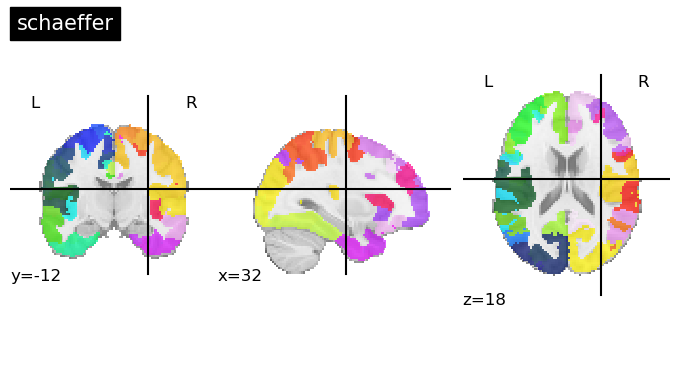

In [5]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.plot()

In [6]:

masker = atlas.fit_masker()
control_ts = []
AD_ts = []
for index, subrow in rest_dataset.iterrows():
    # Preloading with nib is faster than passing a string path
    # to nilearn
    img = nib.load(subrow.file_path)
    confounds, sample_mask = load_confounds(
        subrow.file_path,
        **confounds_strategy
    )
    ts = masker.transform(img, confounds, sample_mask)
    if subrow.declared_dementia:
        AD_ts.append(ts)
    else:
        control_ts.append(ts)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

In [7]:
AD_gsc = GroupSparseCovariance()
control_gsc = GroupSparseCovariance()
sc = StandardScaler() # Could be refactored in a more elegant way but whatever
AD_gsc.fit([sc.fit_transform(ts) for ts in AD_ts])
control_gsc.fit([sc.fit_transform(ts) for ts in control_ts])

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/connectome/group_sparse_cov.py:496: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/connectome/group_sparse_cov.py:496: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


GroupSparseCovariance()

In [89]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# TODO Macro labelling, should be added in atlases?
# => vline
# TODO Symmetry around 0 for precision matrices
from matplotlib.ticker import FixedLocator

def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing."""
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    networks = np.array(list(map(lambda x: str(x).split("_")[2], labels)))
    sort_index = np.argsort(networks)

    # Display covariance matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    sns.heatmap(cov[np.ix_(sort_index, sort_index)], ax=ax1, vmin=-1, vmax=1, cmap="seismic")
    sns.heatmap(prec[np.ix_(sort_index, sort_index)], ax=ax2, cmap="seismic")
    fig.suptitle(title)

    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            ticks.append(i)
            lbls.append(label)
            prev_label = label
    
    ticks.append(i + 1)
    ax1.yaxis.set_minor_locator(FixedLocator(ticks))
    ax1.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    ax1.set_yticklabels(lbls, rotation=0)
    plt.tight_layout()
    plt.show()

    return fig

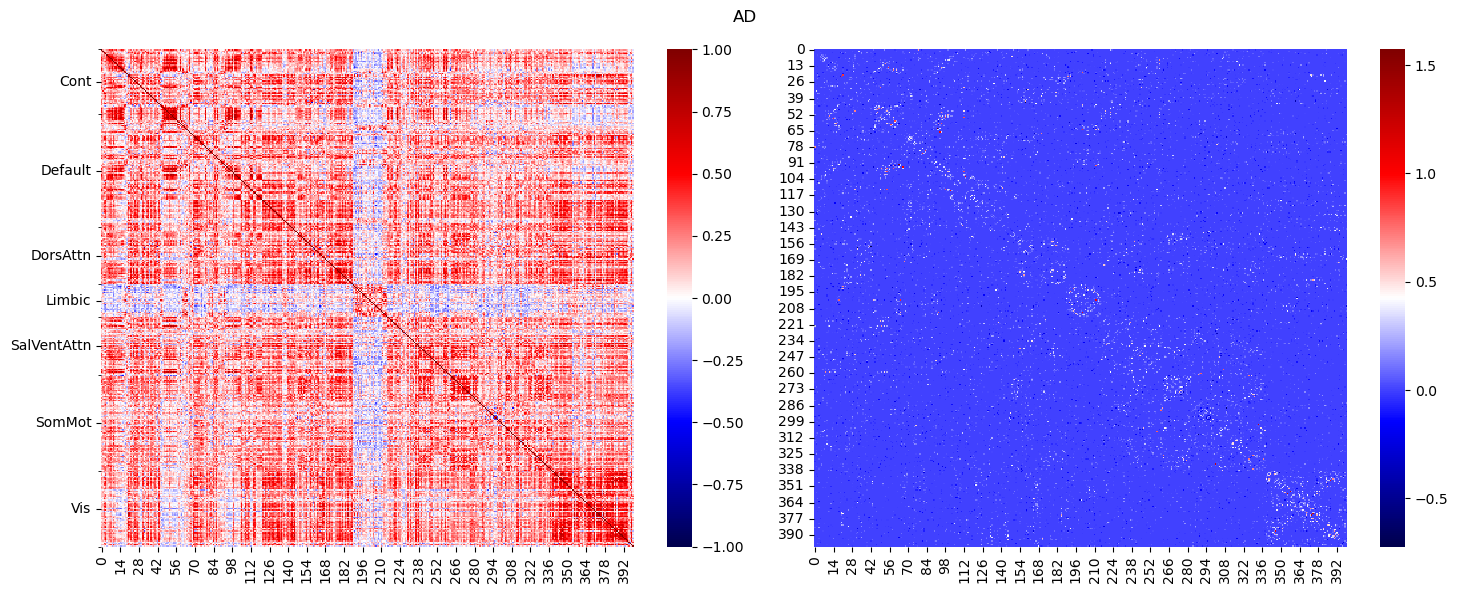

In [90]:
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

#plotting.plot_connectome(
#    -AD_gsc.precisions_.mean(axis=2),
#    atlas.get_coords(),
#    edge_threshold="90%",
#    title=title,
#    display_mode="lzr",
#)
# Mean ou pas mean?
plot_matrices(AD_gsc.covariances_.mean(axis=2), -AD_gsc.precisions_.mean(axis=2), "AD", atlas.labels)

plotting.show()

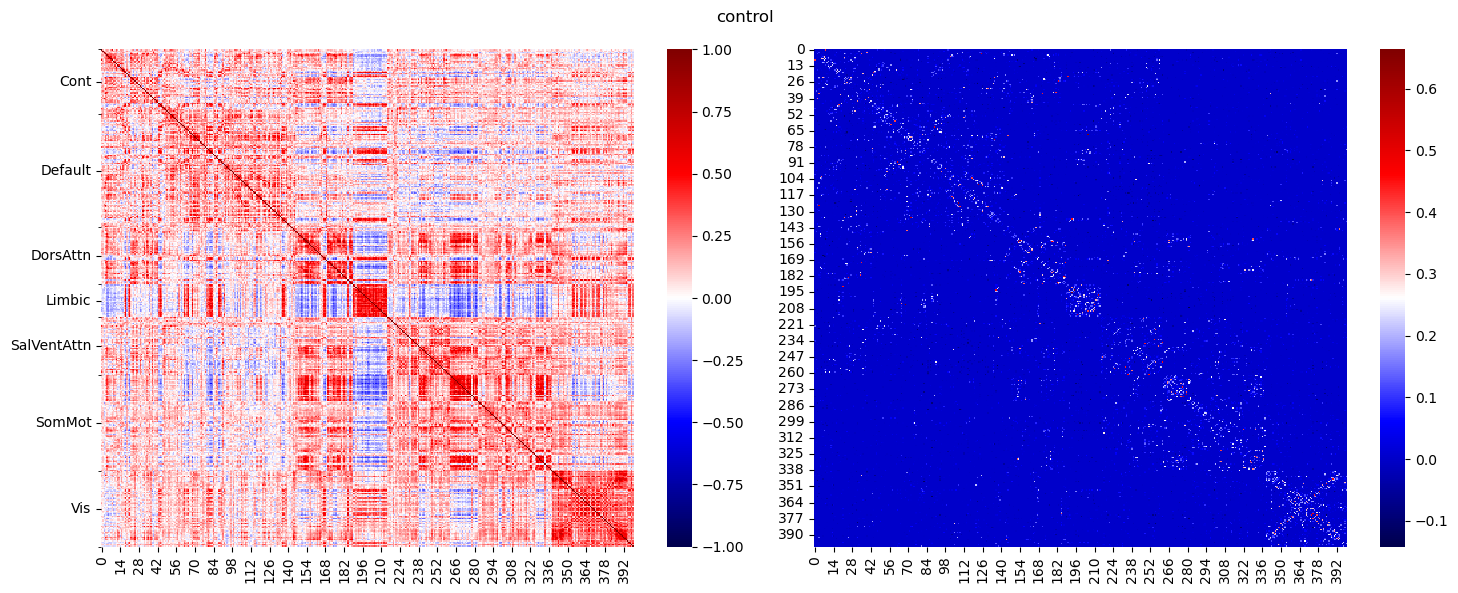

In [88]:
#plotting.plot_connectome(
#    -control_gsc.precisions_.mean(axis=2),
#    atlas.get_coords(),
#    edge_threshold="90%",
#    title=title,
#    display_mode="lzr",
#)

# Mean ou pas mean?
plot_matrices(control_gsc.covariances_.mean(axis=2), -control_gsc.precisions_.mean(axis=2), "control", atlas.labels)

plotting.show()

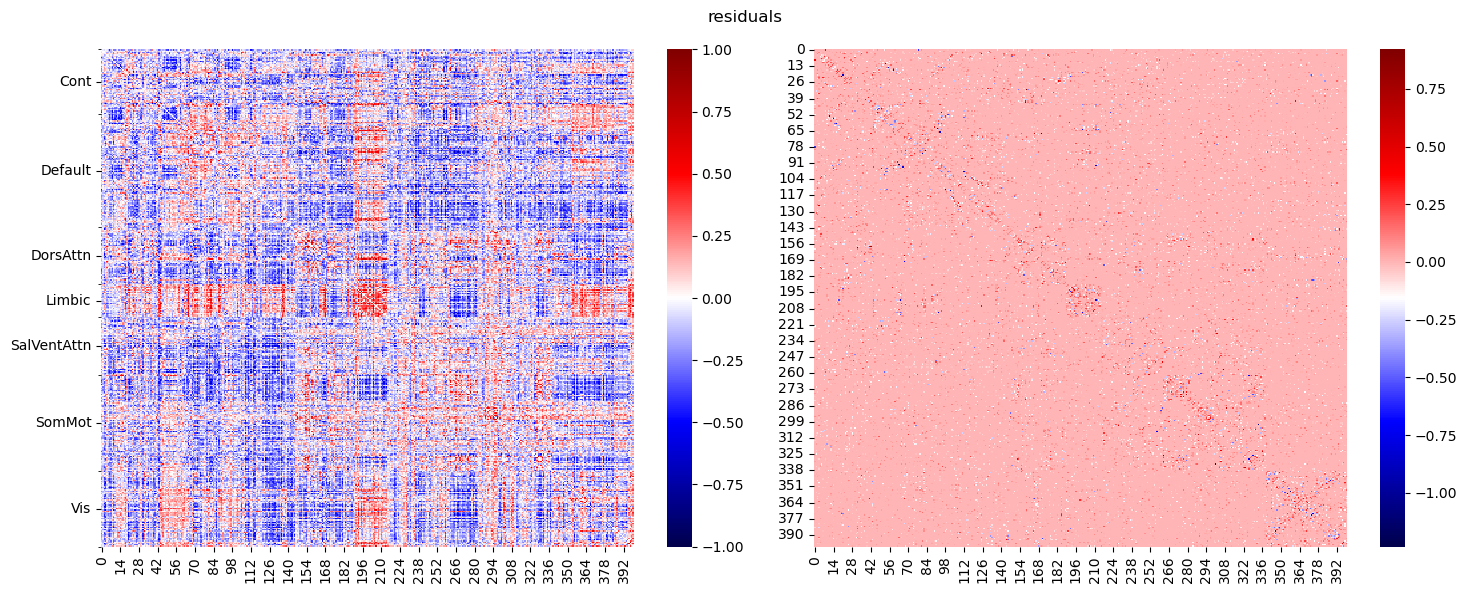

In [92]:

plot_matrices(control_gsc.covariances_.mean(axis=2) - AD_gsc.covariances_.mean(axis=2), -control_gsc.precisions_.mean(axis=2) + AD_gsc.precisions_.mean(axis=2), "residuals", atlas.labels)
plotting.show()

In [94]:
len(AD_ts)

1